## Classification

In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from conf import PROFILE_DIR
from src.img_preprocessing import tf_clean_profile, overview

In [3]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.3.1
Keras version: 2.4.0


In [4]:
# Define CNN architecture
model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(256,256, 1)),
    keras.layers.Conv2D(64, 7, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(7, activation="softmax")
])

In [5]:
# Compile model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    metrics=["accuracy"]
)

In [6]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       2

In [7]:
# Plot model
# keras.utils.plot_model(model)

In [8]:
# Load training set
train_ds = keras.preprocessing.image_dataset_from_directory(
  PROFILE_DIR,
  validation_split=0.1,
  subset="training",
  seed=0,
)

Found 1056 files belonging to 7 classes.
Using 951 files for training.


In [9]:
# Load validation set
val_ds = keras.preprocessing.image_dataset_from_directory(
  PROFILE_DIR,
  validation_split=0.1,
  subset="validation",
  seed=0,
)

Found 1056 files belonging to 7 classes.
Using 105 files for validation.


In [10]:
# Classes
class_names = train_ds.class_names
print(class_names)

['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6']


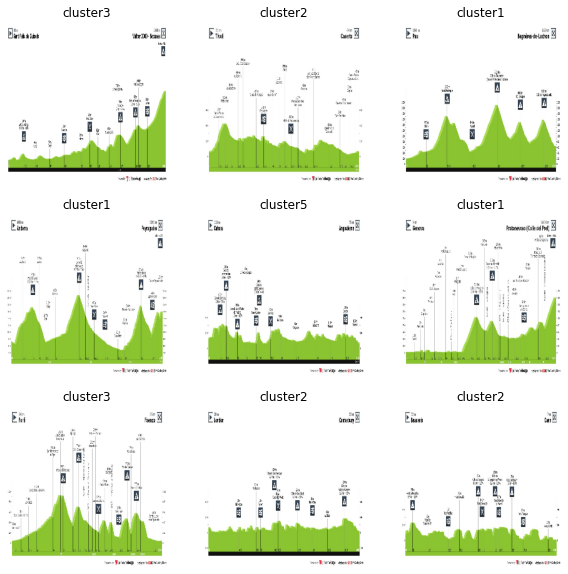

In [11]:
# Overview before preprocessing
overview(train_ds, class_names)

In [12]:
# Preprocess images
train_ds = train_ds.map(tf_clean_profile)
train_ds = train_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
val_ds = val_ds.map(tf_clean_profile)
val_ds = val_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

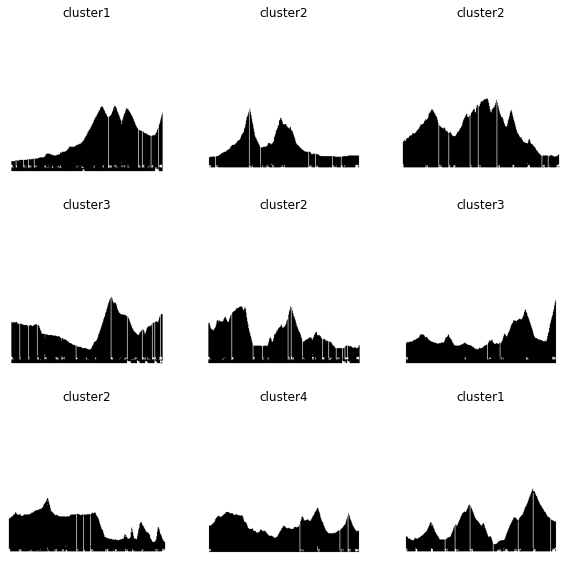

In [13]:
# Overview after preprocessing
overview(train_ds, class_names, cmap="gray")

In [14]:
# Configure dataset for performance
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# Train model
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping_cb]
)

Epoch 1/30
30/30 [==============================] - 133s 4s/step - loss: 2.3669 - accuracy: 0.2566 - val_loss: 1.7732 - val_accuracy: 0.2286
Epoch 2/30
30/30 [==============================] - 132s 4s/step - loss: 1.7741 - accuracy: 0.2755 - val_loss: 1.7312 - val_accuracy: 0.3143
Epoch 3/30
30/30 [==============================] - 132s 4s/step - loss: 1.7905 - accuracy: 0.2723 - val_loss: 1.7608 - val_accuracy: 0.2286
Epoch 4/30
30/30 [==============================] - 133s 4s/step - loss: 1.7592 - accuracy: 0.2692 - val_loss: 1.7051 - val_accuracy: 0.3143
Epoch 5/30
30/30 [==============================] - 132s 4s/step - loss: 1.7560 - accuracy: 0.2808 - val_loss: 1.7132 - val_accuracy: 0.3810
Epoch 6/30
30/30 [==============================] - 132s 4s/step - loss: 1.7528 - accuracy: 0.2850 - val_loss: 1.6565 - val_accuracy: 0.4000
Epoch 7/30
30/30 [==============================] - 134s 4s/step - loss: 1.6924 - accuracy: 0.3449 - val_loss: 1.5582 - val_accuracy: 0.4476
Epoch 8/30
30

[(0.0, 3.0)]

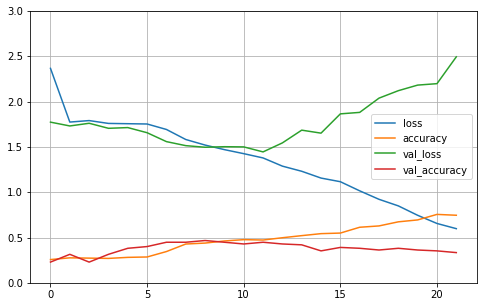

In [16]:
# Plot learning curves
fig, ax = plt.subplots(figsize=(8, 5))
pd.DataFrame(history.history).plot(ax=ax)
ax.grid()
ax.set(ylim=(0, 3))

In [19]:
# Save model
model.save("../model/clf.h5")